## One phase flow.
### pezoflow equation.

$$\frac{\partial \rho_o m}{\partial t} + \frac{\partial}{\partial x}(\rho_o W_o)=0$$
$$W_o=-\frac{k}{\mu_o}\frac{\partial p}{\partial x}$$
$$m(p)=m_0+\beta_r*(p-p_0)$$
$$\rho_{o}(p) = \rho_{o0}(1 + \beta_{o}*(p-p_0))$$

$$x\in[0,L]$$
$$t\in[0,T]$$

*Initial and boundary conditions*
$$p(0<=x<=L/2, t=0)=p_{left}$$
$$p(L/2<x<=L, t=0)=p_{right}$$
$$p(x=0, t)=p_{left}$$
$$p(x=L, t)=p_{right}$$

1. $$ m \rho_{o0} \beta_{o}\frac{\partial p}{\partial t} + \rho_o \beta_r \frac{\partial p}{\partial t}-\frac{\partial}{\partial x}(\rho_o \frac{k}{\mu_o}\frac{\partial p}{\partial x})=0$$

2. $$ \frac{\partial p}{\partial t} (m \rho_{o0} \beta_{o} + \rho_o \beta_r) -\frac{\partial}{\partial x}(\rho_o \frac{k}{\mu_o}\frac{\partial p}{\partial x})=0$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import newton_krylov, fsolve
from scipy.interpolate import interp1d
from sol_plot import solution_plot


def expit(x):
    return 1 / (1 + np.exp(-x))


In [124]:
class OnePhase():
    def __init__(self,
                 mu_h,
                 mu_o,
                 glad,
                 G,
                 k,
                 m0,
                 beta_r,
                 rho_o0,
                 beta_o,
                 t_0,
                 tt,
                 T,
                 nt,
                 pow_n,
                 x_0,
                 L,
                 nx,
                 p_left,
                 p_right,
                 mu_type,
                 Q=None) -> None:
        self.mu_h = mu_h
        self.mu_o = mu_o
        self.glad = glad
        self.G = G
        self.k = k
        self.m0 = m0
        self.Q = Q
        self.beta_r = beta_r
        self.rho_o0 = rho_o0
        self.beta_o = beta_o
        self.t_0 = t_0
        self.tt = tt,
        self.T = T
        self.nt = nt
        self.pow_n = pow_n
        self.x_0 = x_0
        self.L = L
        self.nx = nx
        self.p_left = p_left
        self.p_right = p_right
        self.time = np.linspace(t_0, T, int(nt), dtype=np.float64)
        self.tt = self.time.flat[np.abs(self.time - tt).argmin()]
        self.dt = self.time[1]-self.time[0]
        self.x = np.linspace(0, L, nx, dtype=np.float64)
        self.dx = self.x[1]-self.x[0]
        self.mu_oil_arr = []
        self.grad_p = []
        self.grad_mu = []
        self.mu_stop = np.zeros_like(self.x)
        if mu_type not in ["mu_stop", "mu_run", "mu_new", 'mu']:
            raise NameError
        self.mu_type = mu_type
        # self.p_0 = lambda coord : np.where(coord<=L/2, np.ones_like(coord)*self.p_left, np.ones_like(coord)*self.p_right)
        self.p_0 = lambda coord : np.where(coord<=L/1000, np.ones_like(coord)*self.p_right, np.ones_like(coord)*self.p_right)

    def m(self, p, x):
        return self.m0 + self.beta_r*(p-self.p_0(x))

    def rho_o(self, p, x):
        return self.rho_o0*(1+self.beta_o*(p-self.p_0(x)))

    def mu_oil(self, grad, grad_old, mu_stop):
        grad = abs(grad)
        grad_old = abs(grad_old)
        mu = (self.mu_h-self.mu_o) * expit (self.glad * (-grad + self.G)) + self.mu_o
        mu_new = (self.mu_h/1. - self.mu_o) * expit (self.glad * (-grad + self.G/5)) + self.mu_o
        if self.mu_type=='mu_stop':
            res = np.where(mu<=self.mu_o*1.01, 1, 0)
            res = np.where(mu_stop+res>=1, 1, 0)
            result = np.where(res==1, self.mu_o, mu)
        elif self.mu_type=='mu_run':
            result = mu
            res = None
        elif self.mu_type=='mu_new':
            res = np.where(mu<=self.mu_o*1.01, 1, 0)
            res = np.where(mu_stop+res>=1, 1, 0)
            result = np.where(res==1, mu_new, mu)
        else:
            res = np.where(grad>grad_old, grad, grad_old)
            result = (self.mu_h-self.mu_o) * expit (self.glad * (-res + self.G)) + self.mu_o
        return result, res

    def lam_o(self, p, grad, grad_old, mu, x):
        return self.k*self.rho_o(p, x) / self.mu_oil(grad, grad_old, mu)[0]

    def coef_dp_dt(self, p, x):
        return self.m(p, x)*self.beta_o*self.rho_o0+self.rho_o(p, x)*self.beta_r

    def solution_init(self):
        p = np.zeros((self.nt, self.nx), dtype=np.float64)
        p[0, :] = self.p_0(self.x)
        # p[:,0] = self.p_left
        p[:,-1] = self.p_right
        return p

    def grad(self, p, dx, axis):
        res = np.ones_like(p)
        if axis=='left':
            res[1:] = (p[1:]-p[:-1])/dx
            res[0] = (p[1]-p[0])/dx
        elif axis=='right':
            res[:-1] = (p[1:]-p[:-1])/dx
            res[-1] = (p[-1]-p[-2])/dx
        else:
            res = np.gradient(p, dx)
        return res

    def rate(self, t):
        n = self.pow_n
        a = self.Q*(self.T-self.t_0) / (self.tt**(n+1)/(n+1) + self.tt**n*(self.T-self.tt))
        return np.where(t<self.tt,a*t**(n),a*self.tt**(n))

    def residual(self, u_new, u_old, t_step, dt, dx):
        """Выражение невязки для метода Ньютона-Крылова."""
        N = len(u_new)
        res = np.zeros(N, dtype=np.float64)
        grad = self.grad(u_new, self.dx, axis='center')
        grad_old = self.grad_mu[-1]

        k_left_o = self.lam_o(u_new[1:-1], grad[1:-1], grad_old[1:-1], self.mu_stop[1:-1], self.x[1:-1])
        k_right_o = self.lam_o(u_new[2:], grad[2:], grad_old[2:], self.mu_stop[2:], self.x[2:])

        res[1:-1] = self.coef_dp_dt(u_new[1:-1], self.x[1:-1])*(u_new[1:-1] - u_old[1:-1]) / dt - \
                    (k_right_o*(u_new[2:] - u_new[1:-1]) / dx**2 - k_left_o*(u_new[1:-1] - u_new[:-2]) / dx**2)

        # Граничные условия
        if self.Q is None:
            res[0] = u_new[0] - self.p_0(self.x[0])
        else:
            res[0] = (u_new[1] - u_new[0]) / dx * self.k / self.mu_o + self.rate(t_step)
        res[-1] = u_new[-1] - self.p_0(self.x[-1])

        return res

    # Метод Ньютона-Крылова для решения нелинейной системы
    def solve_nonlinear(self, u_old, t_step, dt, dx):
        """Решение системы уравнений с использованием метода Ньютона-Крылова."""
        u_new_guess = np.copy(u_old)  # начальное предположение
        u_new = newton_krylov(lambda u_new: self.residual(u_new, u_old, t_step, dt, dx), u_new_guess, x_rtol=1e-4)
        return u_new

    def solve(self):
        p = self.solution_init()
        mu_oil_init = np.zeros(self.nx, dtype=np.float64)+self.mu_h
        self.mu_oil_arr.append(mu_oil_init)
        self.grad_p.append(self.grad(p[0,:], self.dx, 'center'))
        self.grad_mu.append(self.grad(p[0,:], self.dx, 'center'))
        # Решение системы с использованием Ньютона-Крылова
        for t, t_step in enumerate(self.time[:-1]):
            # решение уравнения для давления
            p_old = p[t, :].copy()
            p_new = self.solve_nonlinear(p_old, t_step, self.dt, self.dx)
            p[t+1, :] = p_new.copy()
            grad_new = self.grad(p_new, self.dx, 'center')

            if t>=0:
                mu_oil_new, grad_old = self.mu_oil(grad_new, self.grad_mu[-1], self.mu_stop)
                res = np.where(mu_oil_new==self.mu_o, 1, 0)
                self.mu_stop = np.where(self.mu_stop+res>=1, 1, 0)
                self.grad_mu.append(grad_old)
            self.mu_oil_arr.append(mu_oil_new)
            self.grad_p.append(grad_new)
        self.mu_oil_arr = np.array(self.mu_oil_arr)
        self.grad_p = np.array(self.grad_p)
        return p

In [133]:
solver = OnePhase(mu_h = 8e-3,
                mu_o = 2e-3,
                glad = 0.00004,
                G = 0.4e7,
                k = 1e-15,
                m0 = 0.2,
                beta_r = 1e-10,
                rho_o0 = 800.,
                beta_o = 5e-9, # посмотреть в таблице
                t_0 = 0,
                tt=0.05*10*86400,
                T = 10*86400,
                nt = 150*5,
                pow_n = 2,
                x_0 = 0,
                L = 100,
                nx = 50,
                p_left = 50e+6,
                p_right = 1e+6,
                mu_type = "mu_stop",
                Q=-0.2/86400)

p = solver.solve() 

G = -np.ones_like(solver.grad_p)*solver.G

C:\Users\damir.aminev\AppData\Local\Temp\ipykernel_17284\742843218.py:10: RuntimeWarning:

overflow encountered in exp



In [134]:
solution_plot([[solver.x, p],
               [solver.x, solver.mu_oil_arr],
               [solver.x, abs(G)],
            #    [solver.x, abs(G)/5],
               [solver.x, abs(solver.grad_p)],
               [solver.x, -solver.k/solver.mu_oil_arr*solver.grad_p]],
               titles=("Pressure (p) vs x", "mu_oil", "grad(p)", 'w_oil'),
               idx=[[1,1], [1,2], [2,1], [2,1], [2,2]],
               nt=solver.nt,
               height=1000,
               width=1200)


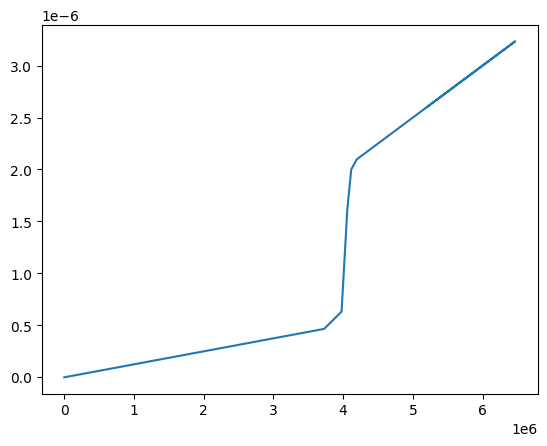

In [140]:
plt.plot(abs(solver.grad_p[:, 7]), solver.k*solver.grad_p[:, 7]/solver.mu_oil_arr[:, 7])